In [1]:
# import mxnet
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import find_mxnet
import mxnet as mx

In [2]:
# download vgg16 pretrained model (skipping download if the local file exists)
path='http://data.mxnet.io/models/imagenet/'
[mx.test_utils.download(path+'vgg/vgg16-symbol.json', fname='../model/imagenet1k-vgg16-symbol.json'),
 mx.test_utils.download(path+'vgg/vgg16-0000.params', fname='../model/imagenet1k-vgg16-0000.params'),
 mx.test_utils.download(path+'synset.txt', fname='../model/imagenet1k-synset.txt')]

['../model/imagenet1k-vgg16-symbol.json',
 '../model/imagenet1k-vgg16-0000.params',
 '../model/imagenet1k-synset.txt']

In [3]:
# To run your fine-tuned model, change model_prefix, model_epoch and labels_file.
model_prefix = '../model/imagenet1k-vgg16'
model_epoch = 0
labels_file = '../model/imagenet1k-synset.txt'

sym, arg_params, aux_params = mx.model.load_checkpoint(model_prefix, model_epoch)

# Use CPU to inference
mod = mx.mod.Module(symbol=sym, context=mx.cpu(), label_names=None)
# When GPU is available
# mod = mx.mod.Module(symbol=sym, context=mx.gpu(), label_names=None)

mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True)

with open(labels_file, 'r') as f:
    labels = [l.rstrip() for l in f]

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
from collections import namedtuple
Batch = namedtuple('Batch', ['data'])

def get_image(url, show=False):
    # download and show the image
    fname = mx.test_utils.download(url)
    img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)
    if img is None:
         return None
    if show:
         plt.imshow(img)
         plt.axis('off')
    # convert into format (batch, RGB, width, height)
    img = cv2.resize(img, (224, 224))
    img = np.swapaxes(img, 0, 2)
    img = np.swapaxes(img, 1, 2)
    img = img[np.newaxis, :]
    return img

def classify(url):
    img = get_image(url, show=True)
    # compute the predict probabilities
    mod.forward(Batch([mx.nd.array(img)]))
    prob = mod.get_outputs()[0].asnumpy()
    # print the top-5
    prob = np.squeeze(prob)
    a = np.argsort(prob)[::-1]
    for i in a[0:5]:
        print('probability=%f, class=%s' %(prob[i], labels[i]))

probability=0.976111, class=n02110958 pug, pug-dog
probability=0.009251, class=n02086079 Pekinese, Pekingese, Peke
probability=0.002903, class=n02112137 chow, chow chow
probability=0.002153, class=n02108422 bull mastiff
probability=0.001457, class=n03223299 doormat, welcome mat


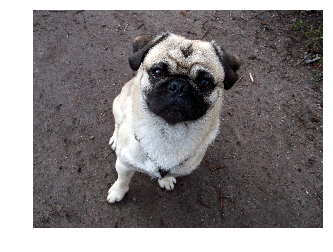

In [5]:
classify('https://cdn.pixabay.com/photo/2016/09/05/15/32/pug-1646844_1280.jpg')

probability=0.999999, class=n02129165 lion, king of beasts, Panthera leo
probability=0.000001, class=n02130308 cheetah, chetah, Acinonyx jubatus
probability=0.000000, class=n02125311 cougar, puma, catamount, mountain lion, painter, panther, Felis concolor
probability=0.000000, class=n02410509 bison
probability=0.000000, class=n02127052 lynx, catamount


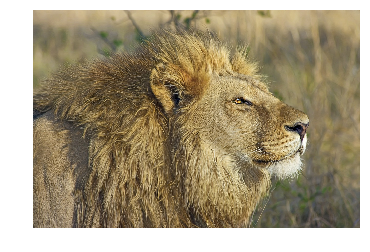

In [6]:
classify('https://cdn.pixabay.com/photo/2014/11/03/11/07/lion-515028_1280.jpg')